# Conocimiento de código

## Librerías y funciones

In [147]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler




import random

def ver_Nan(df,columns):
    for column in columns:
        text = f'NaN? - {column.upper()} '
        
        isNa = df[column].isna().any()
        print(f'{text.ljust(50)} {isNa}')

def standard_scale(df):
    '''Devuelve un dataframe con las columnas escaladas'''
    scaler = StandardScaler()
    string = df.select_dtypes(include=['object']).columns #solo vamos a escalar las columnas que no son string
    df_no_string = df.drop(string,axis=1)
    df_no_string = scaler.fit_transform(df_no_string)
    df_no_string = pd.DataFrame(df_no_string,columns=df.drop(string,axis=1).columns)
    df_escaled = df.copy()
    df_escaled[df_no_string.columns] = df_no_string
    return df_escaled

def boxplot(df):
    '''Devuelve un boxplot de df'''
    df_escaled = standard_scale(df)
    sns.boxplot(data=df_escaled,orient='h')

def rango_outliers(df):
    '''Devuelve el rango de outliers de df, definidas por min y max'''
    df_escaled = standard_scale(df)
    Q1 = df_escaled.quantile(0.25)
    Q3 = df_escaled.quantile(0.75)
    IQR = Q3 - Q1
    min = Q1 - 1.5*IQR
    max = Q3 + 1.5*IQR
    return min,max

def outliers(df):
    '''Devuelve un dataframe con los outliers de df, y una columna llamada outliers con las columnas que son outliers'''
    df_escaled = standard_scale(df)
    min,max = rango_outliers(df)
    columnas_no_string = df.select_dtypes(exclude=['object']).columns
    premisa = (df_escaled[columnas_no_string] < min) | (df_escaled[columnas_no_string] > max)
    indexes = df_escaled[premisa].dropna(axis=0,how='all').index
    df_outliers_bool = df_escaled[premisa].dropna(axis=0,how='all').isna()
    df_outliers = df.loc[indexes]
    columnas = df_outliers.columns
    dict = {i:[j for j in columnas if df_outliers_bool.loc[i][j] == False] for i in indexes}
    df_outliers['outliers'] = dict.values()
    return df_outliers

def bar_plot(df,column:list):
    length = len(column)
    fig,ax = plt.subplots(1,length,figsize=(20,5))
    for i in range(length):
        #quiero qu lo string se vean en vertical
        sns.countplot(x=column[i],data=df,ax=ax[i])#los strin del eje x se solapan y no se ven, hay que rotarlos
        ax[i].tick_params(axis='x', rotation=90)


        ax[i].set_title(column[i])
        ax[i].set_ylabel('Count')
        ax[i].set_xlabel('')

def corr_representation(train):
    ax, fig = plt.subplots(1,3,figsize=(20,5))

    corr_1 = train['Comb (L/100 km)'].corr(train['Fuel Consumption City (L/100 km)'])
    corr_2 = train['Comb (L/100 km)'].corr(train['Hwy (L/100 km)'])
    corr_3 = train['Fuel Consumption City (L/100 km)'].corr(train['Hwy (L/100 km)'])

    fig[0].scatter(train['Comb (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[0].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[0].legend([f'Correlación: {corr_1}'])

    fig[1].scatter(train['Comb (L/100 km)'],train['Hwy (L/100 km)'])
    fig[1].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Hwy (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[1].legend([f'Correlación: {corr_2}'])

    fig[2].scatter(train['Hwy (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[2].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
    fig[2].legend([f'Correlación: {corr_3}'])


def r_2_regresion_lineal(df,x:list,y:list):
    reg = LinearRegression().fit(df[x],df[y])
    parametres = reg.coef_
    ax, fig = plt.subplots(1,3,figsize=(20,5))
    calculo = parametres[0][0]*df[x[0]] + parametres[0][1]*df[x[1]]
    r_2 = reg.score(df[x],df[y])
    fig[0].plot(df[y],calculo,color='red')
    fig[0].scatter(df[y],df[y],color='blue')
    fig[0].set_title(f'r_2: {r_2}')
    error = df['Comb (L/100 km)'] - calculo
    sns.distplot(error,ax=fig[1])

    qqplot(error,ax=fig[2],line='s')

    print(f'r_2: {r_2}')
    print(f'parametres: {parametres}')



    


## Lectura de datos

Vamos a primero comprender los disntintos datasets que nos han facilitado el concurso. Para ello, vamos a cargar los datos y a ver qué información contienen.

In [126]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')


- sample_subsimmision, ejemplo de cómo debe ser el fichero de salida (la predicción)
- test_nolabel, datos de test sin etiquetar (podemos observar que no tenemos la columna de la etiqueta -Smog-)
- train, datos de entrenamiento 



In [91]:
sample_submission.head()

,id,Predicted
0,2be023f9102,2
1,a320ba7de7b,3
2,2879e8fa078,0
3,a561b6ee65b,2
4,94c225dd8e9,1


In [92]:
test_nolabel.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km)
0,2be023f9102,2022,Jeep,Wagoneer 4X4,SUV: Standard,5.7,8,A8,X,15.6,11.7,13.8,20,323
1,a320ba7de7b,2022,Porsche,718 Boxster,Two-seater,2.0,4,M6,Z,11.7,8.9,10.5,27,245
2,2879e8fa078,2022,Chrysler,Grand Caravan,Minivan,3.6,6,A9,X,12.4,8.4,10.6,27,249
3,a561b6ee65b,2022,Kia,Sorento AWD,SUV: Small,2.5,4,AM8,X,10.9,8.7,9.9,29,234
4,94c225dd8e9,2022,Bentley,Continental GT,Subcompact,4.0,8,AM8,Z,14.9,9.0,12.2,23,287


In [93]:
train.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


Nuestras variables son:
- Model Year: año del modelo
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo
- Engine Size: tamaño del motor
- Cylinders: número de cilindros
- Transmission: tipo de transmisión
- Fuel Type: tipo de combustible
- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Fuel Consumption Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones 

## Exploración de atributos

In [94]:
train.info() 




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                586 non-null    object 
 1   Model Year                        586 non-null    int64  
 2   Make                              586 non-null    object 
 3   Model                             586 non-null    object 
 4   Vehicle Class                     586 non-null    object 
 5   Engine Size (L)                   586 non-null    float64
 6   Cylinders                         586 non-null    int64  
 7   Transmission                      586 non-null    object 
 8   Fuel Type                         586 non-null    object 
 9   Fuel Consumption City (L/100 km)  586 non-null    float64
 10  Hwy (L/100 km)                    586 non-null    float64
 11  Comb (L/100 km)                   586 non-null    float64
 12  Comb (mp

In [95]:
test_nolabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                390 non-null    object 
 1   Model Year                        390 non-null    int64  
 2   Make                              390 non-null    object 
 3   Model                             390 non-null    object 
 4   Vehicle Class                     390 non-null    object 
 5   Engine Size (L)                   390 non-null    float64
 6   Cylinders                         390 non-null    int64  
 7   Transmission                      390 non-null    object 
 8   Fuel Type                         390 non-null    object 
 9   Fuel Consumption City (L/100 km)  390 non-null    float64
 10  Hwy (L/100 km)                    390 non-null    float64
 11  Comb (L/100 km)                   390 non-null    float64
 12  Comb (mp

### Variables categoricas

### Model Year

El atributo Model Year es un atributo numérico que representa el año del modelo del coche. 

In [96]:
test_nolabel['Model Year'].unique()

array([2022], dtype=int64)

In [97]:
train['Model Year'].unique()

array([2022], dtype=int64)

Podemos observar que los coches del dataset son modelos del año 2022. Al ser todos del mismo año, este atributo no nos aporta información y por tanto, no lo vamos a tener en cuenta en nuestro modelo.

### Make, Model y Vehicle Class

Vamos a estudiar estos tres atributos juntos, ya que los tres nos aportan información sobre el tipo de coche.
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo

Text(0.5, 1.0, 'Model')

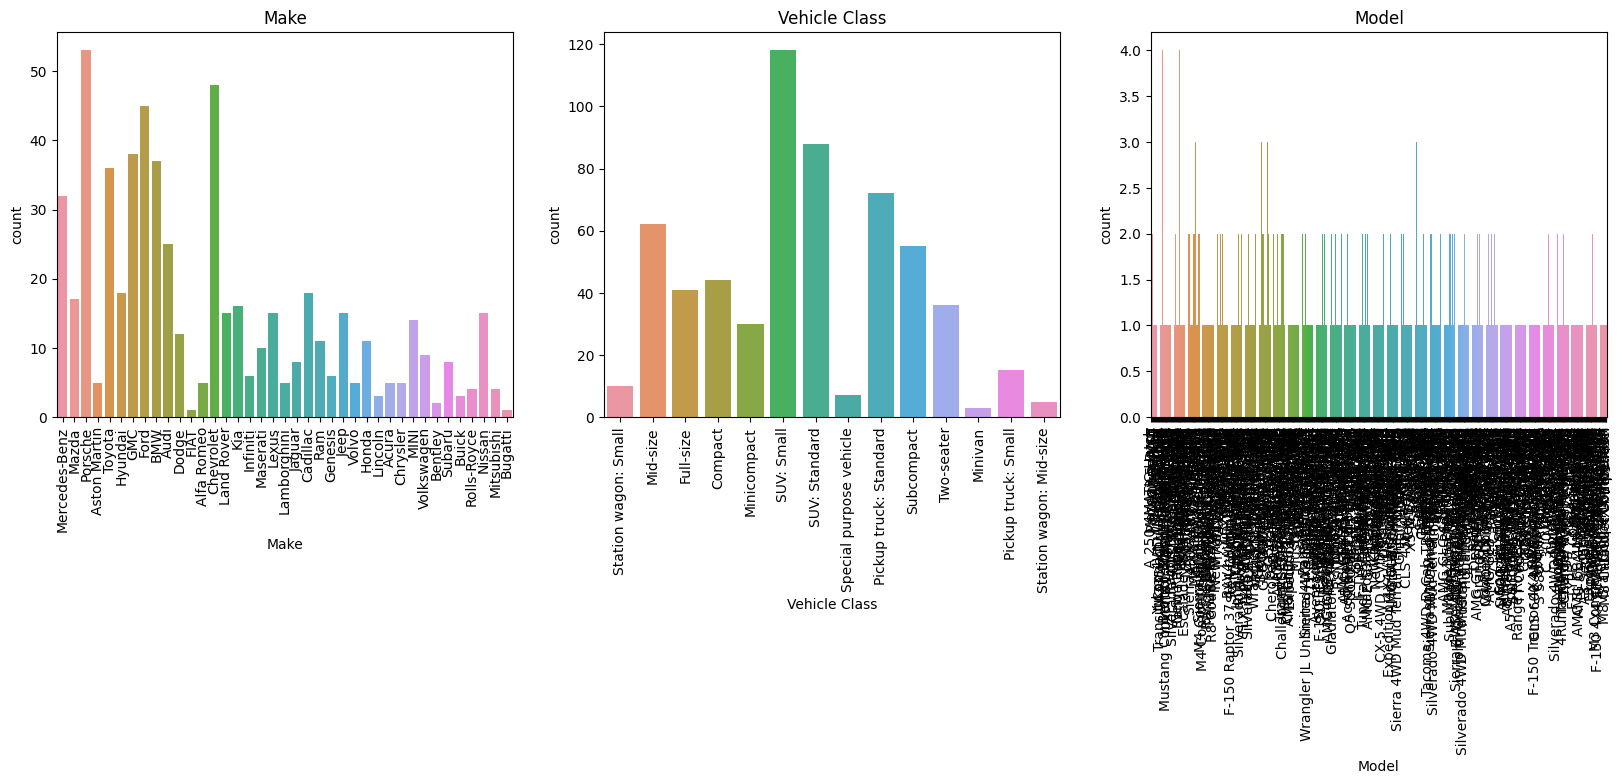

In [98]:
ax,fig = plt.subplots(1,3,figsize=(20,5))  
lista = ['Make','Vehicle Class','Model']

sns.countplot(x=lista[0],data=train,ax=fig[0])
fig[0].tick_params(axis='x', rotation=90)
fig[0].set_title(lista[0])

sns.countplot(x=lista[1],data=train,ax=fig[1])
fig[1].tick_params(axis='x', rotation=90)
fig[1].set_title(lista[1])

sns.countplot(x=lista[2],data=train,ax=fig[2])
fig[2].tick_params(axis='x', rotation=90)
fig[2].set_title(lista[2])

Text(0.5, 1.0, 'Model')

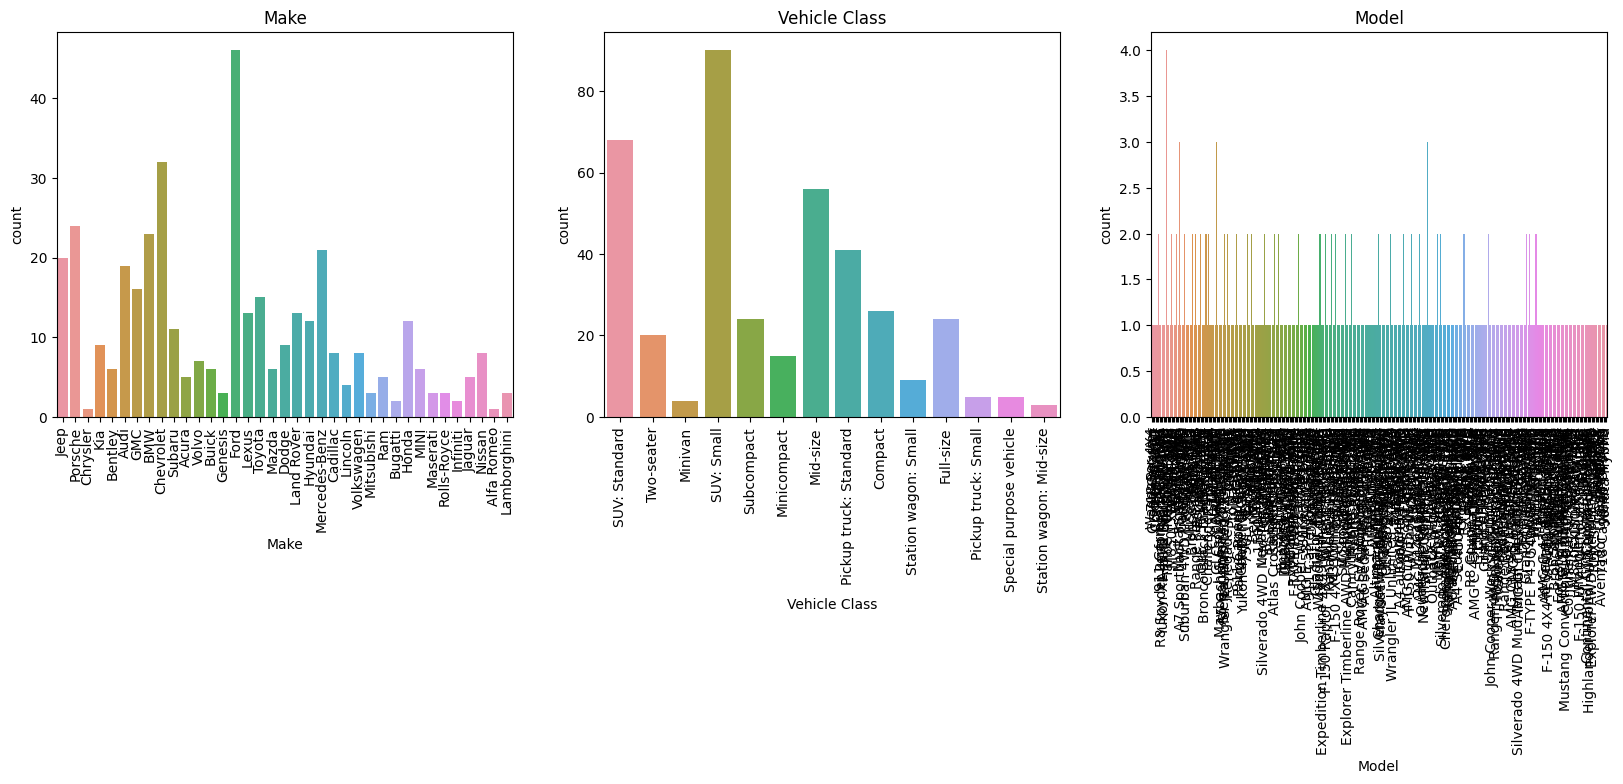

In [99]:
ax,fig = plt.subplots(1,3,figsize=(20,5))

sns.countplot(x=lista[0],data=test_nolabel,ax=fig[0])
fig[0].tick_params(axis='x', rotation=90)
fig[0].set_title(lista[0])

sns.countplot(x=lista[1],data=test_nolabel,ax=fig[1])
fig[1].tick_params(axis='x', rotation=90)
fig[1].set_title(lista[1])

sns.countplot(x=lista[2],data=test_nolabel,ax=fig[2])
fig[2].tick_params(axis='x', rotation=90)
fig[2].set_title(lista[2])

In [100]:
print('train'+lista[0]+':',len(train[lista[0]].unique()))
print('train'+lista[1]+':',len(train[lista[1]].unique()))
print('train'+lista[2]+':',len(train[lista[2]].unique()))
print('train total de datos:',len(train))
print('-'*50)
print('test'+lista[0]+':',len(test_nolabel[lista[0]].unique()))
print('test'+lista[1]+':',len(test_nolabel[lista[1]].unique()))
print('test'+lista[2]+':',len(test_nolabel[lista[2]].unique()))
print('test total de datos:',len(test_nolabel))

trainMake: 39
trainVehicle Class: 14
trainModel: 488
train total de datos: 586
--------------------------------------------------
testMake: 37
testVehicle Class: 14
testModel: 344
test total de datos: 390


Hay demasiados valores diferentes para Model (488-344) en relación al número de instancias (586-390). Por tanto, es difícil para los modelos extraer información particular asociada a cada modelo en particular. Por tanto, vamos a eliminar este atributo para el entrenamiento de los modelos.

### Fuel Type y Transmission

- Fuel Type: tipo de combustible
- Transmission: tipo de transmisión, que puede ser automática o manual<>

In [101]:
train['Fuel Type'].unique()

array(['Z', 'X', 'E', 'D'], dtype=object)

In [102]:
len(train)+len(test_nolabel)

976

In [103]:
train['Transmission'].unique()

array(['AM7', 'AS6', 'AM8', 'A8', 'AS8', 'M6', 'A10', 'AS10', 'A9', 'M7',
       'AV8', 'AS9', 'AV', 'AM6', 'AS7', 'AV10', 'AV7', 'A6', 'AM9', 'M5',
       'AV6', 'AS5', 'AV1'], dtype=object)

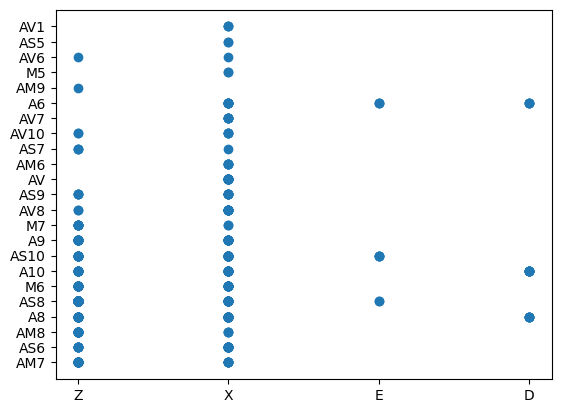

In [104]:
plt.scatter(train['Fuel Type'],train['Transmission'])

No hemos podido sacar nada en claro, respecto si puede una u otra puede ser más eficiente. Por tanto, vamos a dejarlas como están.

Antes de continuar con las variables numéricas, queremos dejar claro que vamos a eliminar las variables Model Year y Model, en relación a las demás variables estudiadas no hemos podido profundizar en su eficacia o la necesidad de dichas variables para el modelo.

### Variables numéricas

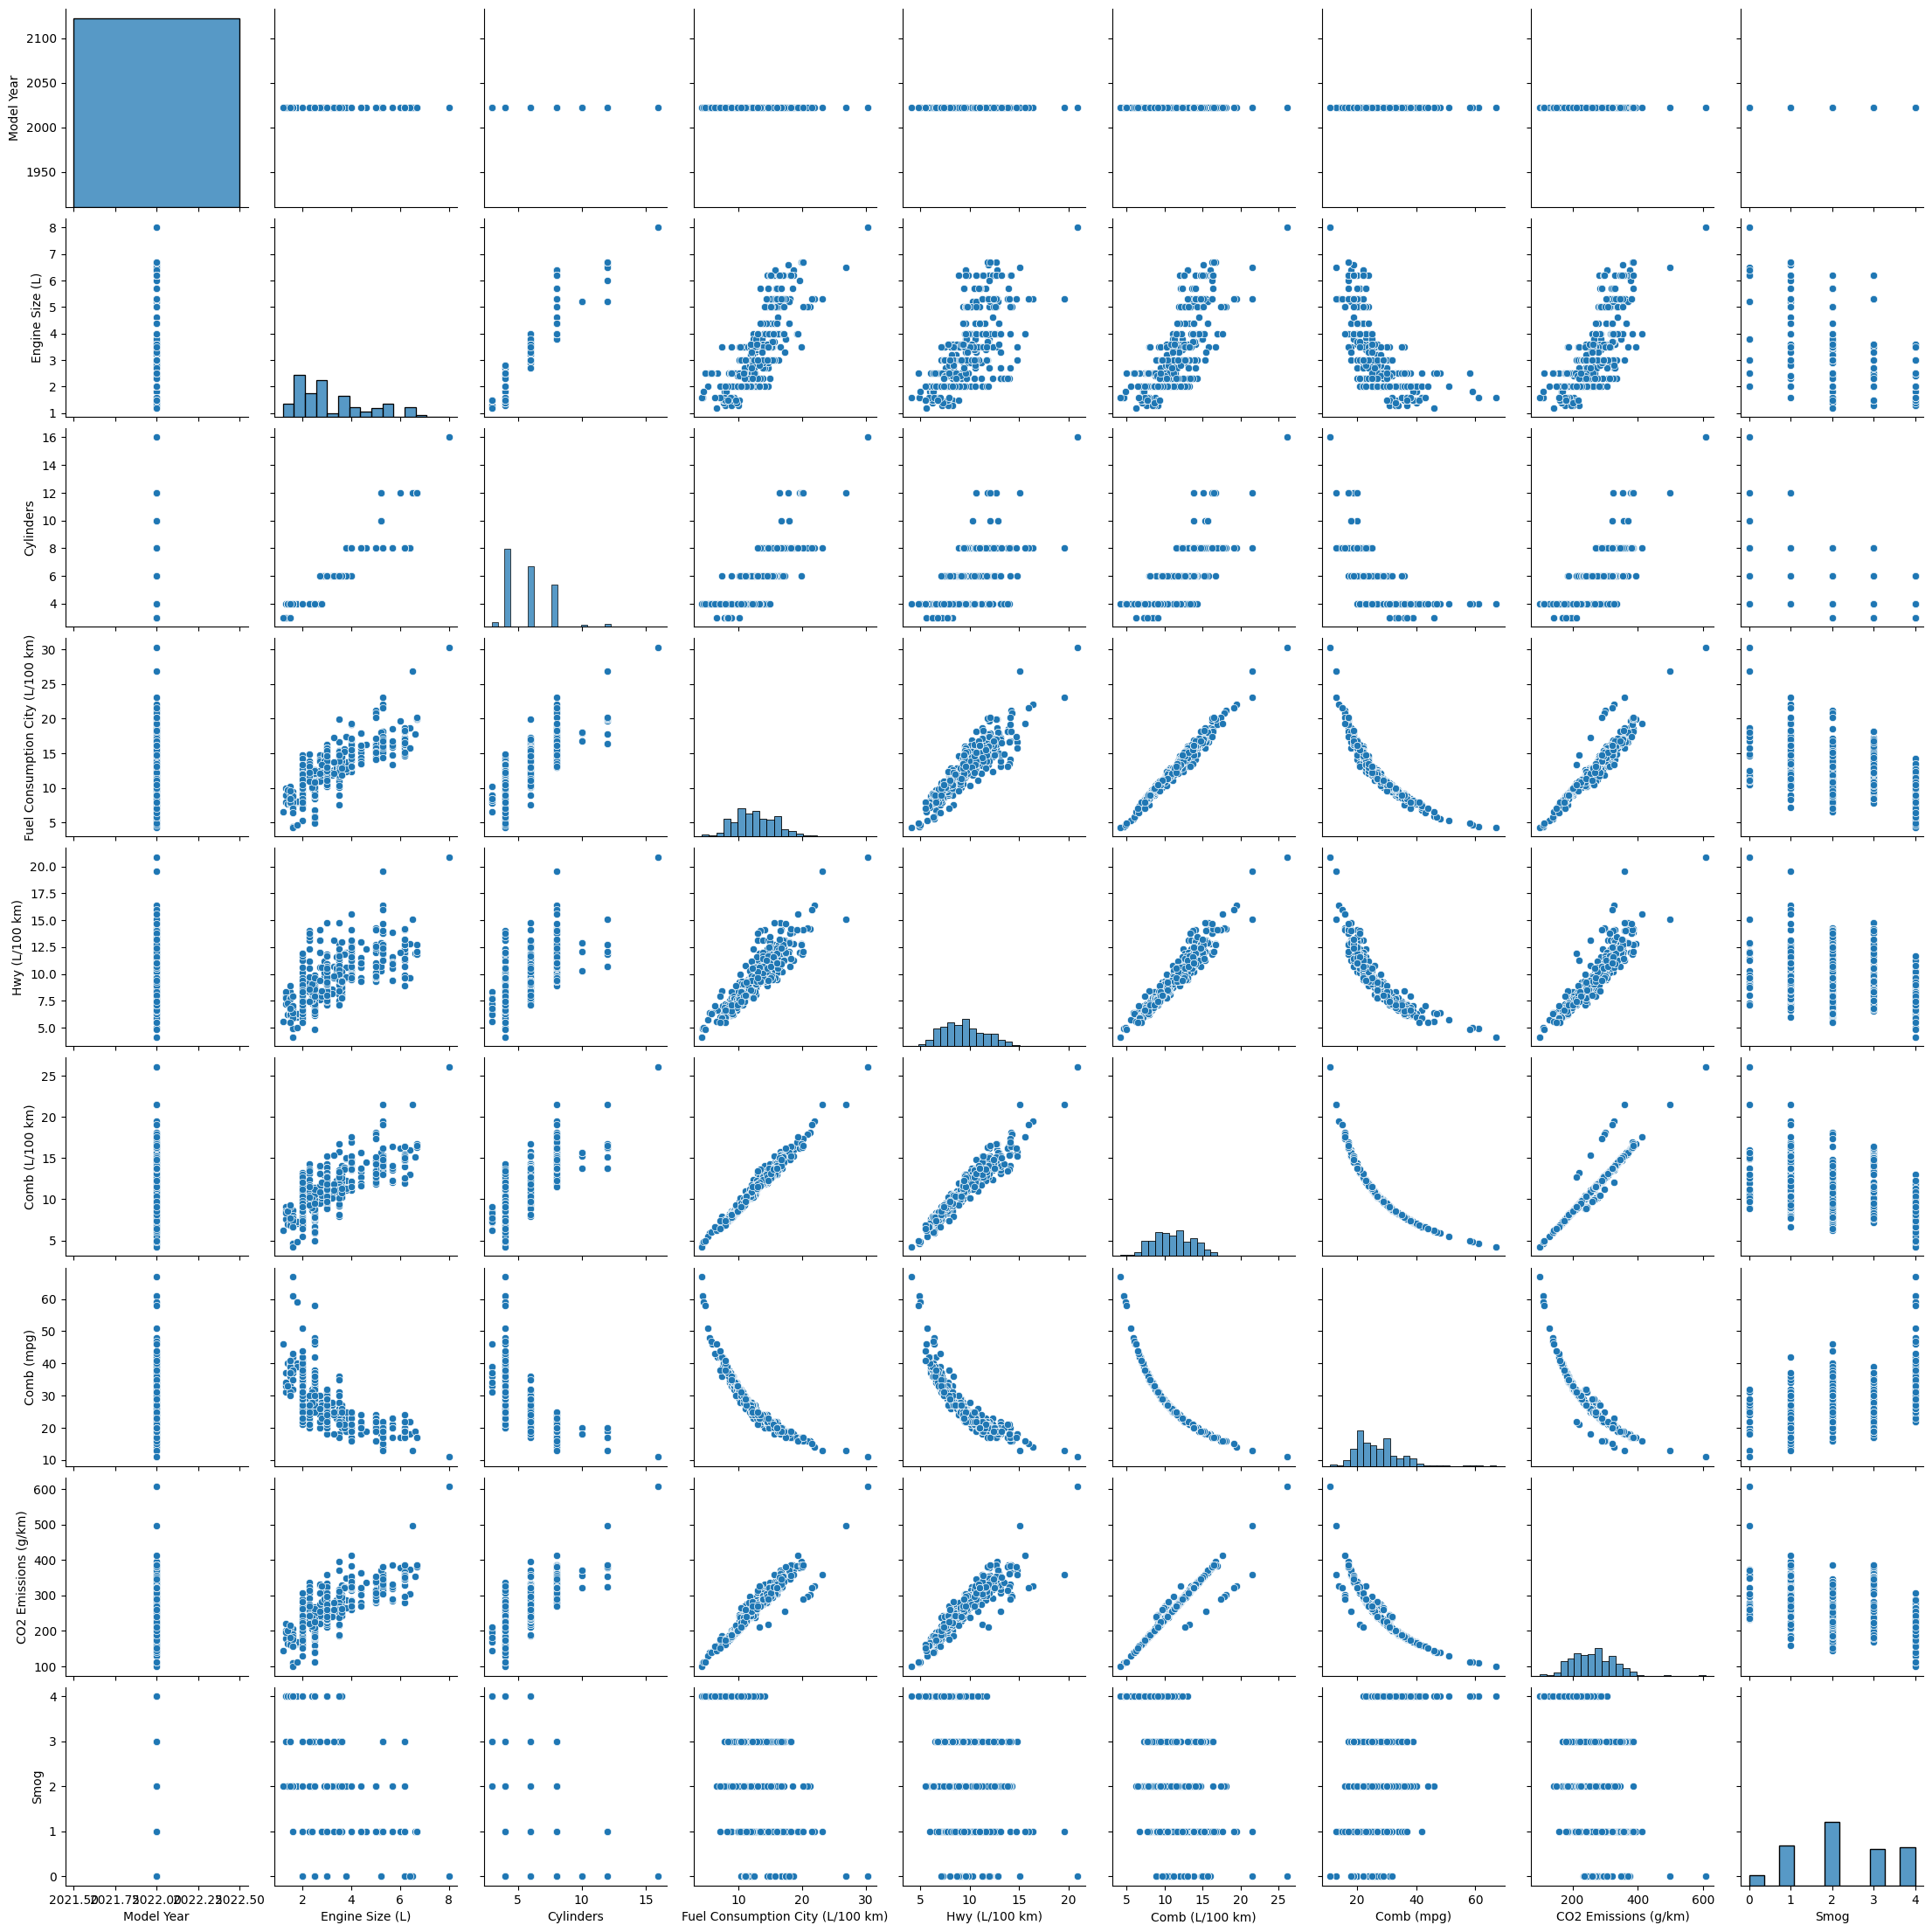

In [105]:
sns.pairplot(train)

<Axes: >

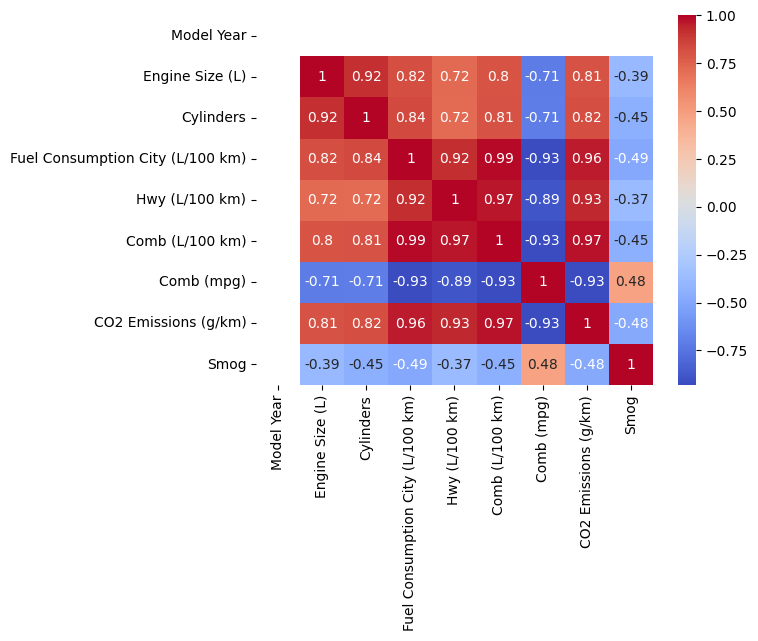

In [106]:
## mapa de calor correalación con sns
columnas_numericas = train.select_dtypes(exclude=['object']).columns
sns.heatmap(train[columnas_numericas].corr(),annot=True,cmap='coolwarm')

Observando  el mapa de calor de correlación, podemos observar que las variables Fuel Consumption City (L/100 km), Hwy (L/100 km), Comb (L/100 km) y Comb (mpg) están muy correlacionadas entre sí. Se estudiará más adelante si es necesario eliminar alguna de ellas.

### Engine Size y Cylinders

- Engine Size: tamaño del motor
- Cylinders: número de cilindros


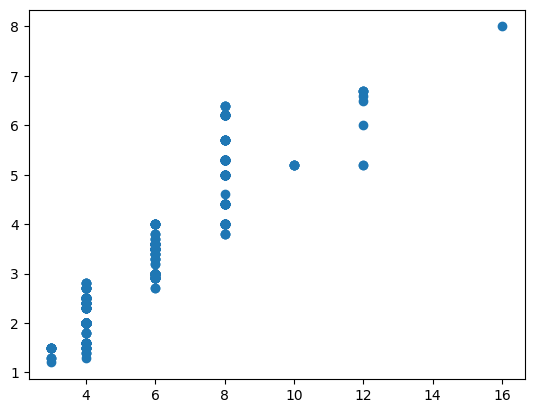

In [107]:
plt.scatter(train['Cylinders'],train['Engine Size (L)'])

### Fuel Consumption City,  Hwy, Comb (L/100 km), Comb (mpg) y CO2 Emissions

- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones

#### Comb (mpg) y Comb (L/100 km)

Podemos observar de primeras que tenemos dos atributos que nos dan la misma información, pero en distintas unidades. Estos son Comb (L/100 km) y Comb (mpg). 

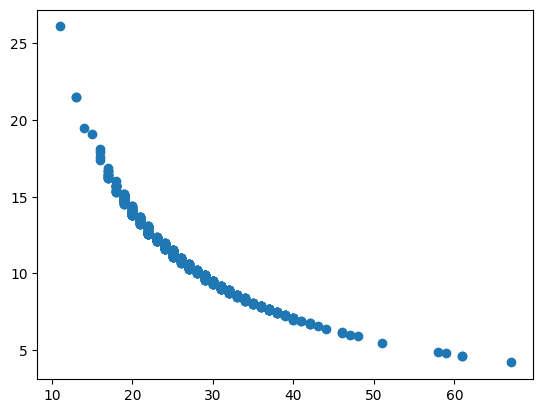

In [108]:
plt.scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])

Para pasar de millas por galón Imperial a litros por 100 km, vamos a utilizar la siguiente fórmula:
- 1 L/100Km = 282 /mpgImperial

In [109]:
train[['Comb (mpg)','Comb (L/100 km)']].head()

,Comb (mpg),Comb (L/100 km)
0,32,8.7
1,37,7.7
2,24,11.7
3,35,8.1
4,20,13.8


Text(0.5, 1.0, 'Comb (mpg) (redondeado) vs Comb (L/100 km)')

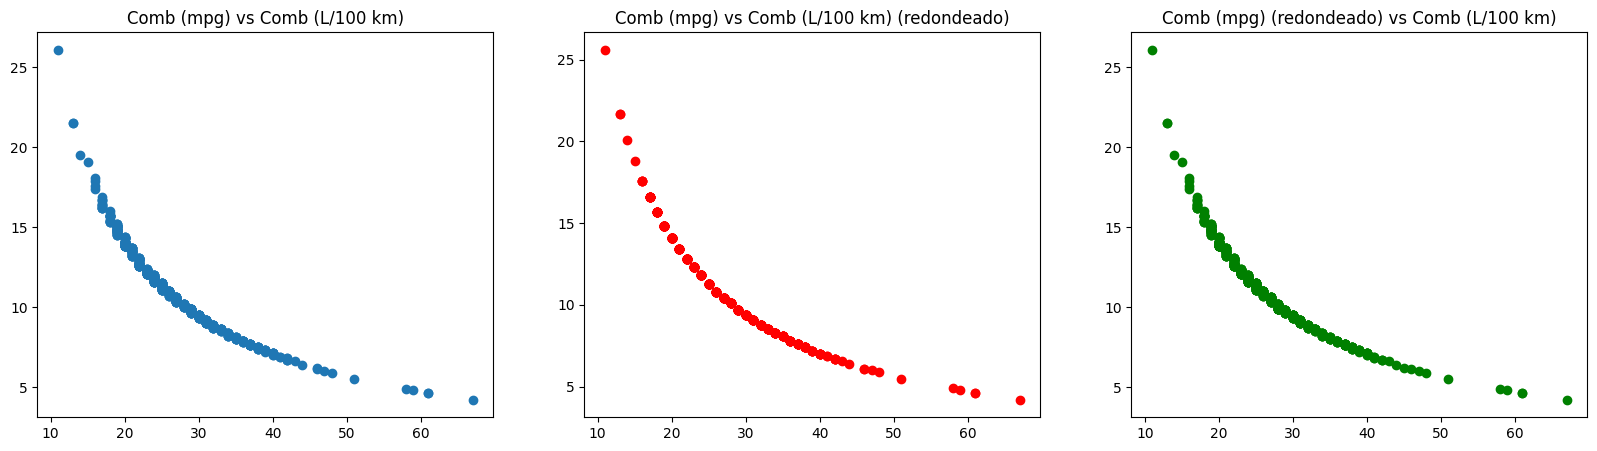

In [110]:
ax,fig = plt.subplots(1,3,figsize=(20,5))

fig[0].scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])
fig[0].set_title('Comb (mpg) vs Comb (L/100 km)')

fig[1].scatter(train['Comb (mpg)'],np.around(282/train['Comb (mpg)'],1),color='red')
fig[1].set_title('Comb (mpg) vs Comb (L/100 km) (redondeado)')

fig[2].scatter(np.around(282/train['Comb (L/100 km)']),train['Comb (L/100 km)'],color='green')
fig[2].set_title('Comb (mpg) (redondeado) vs Comb (L/100 km)')


Text(0.5, 1.0, 'Error redondeo mpg')

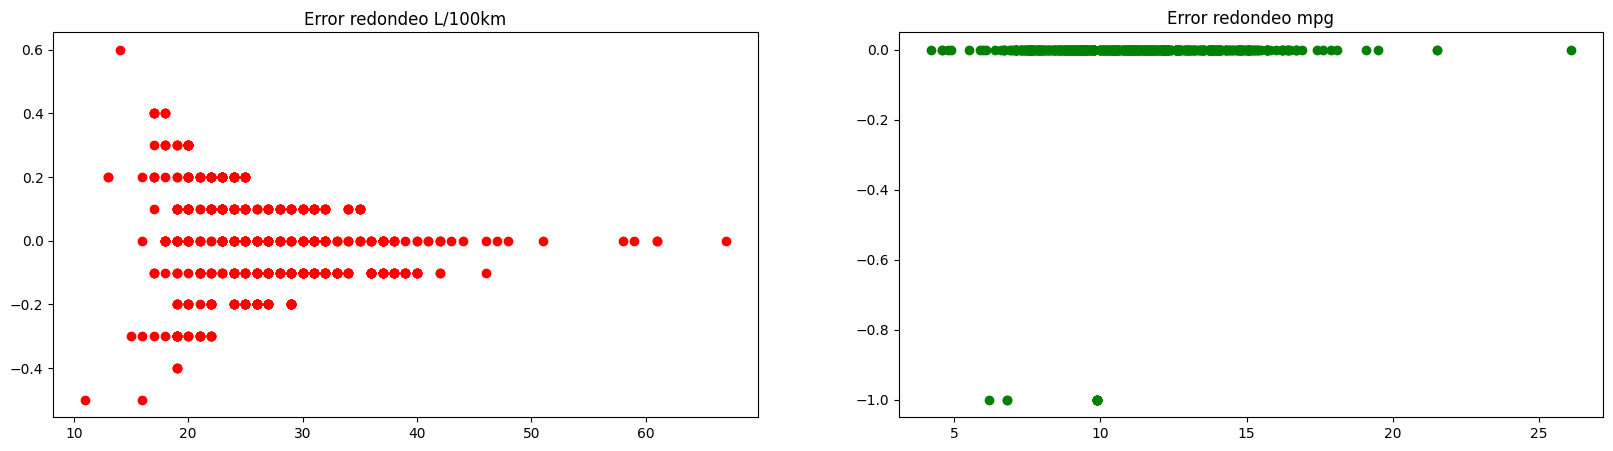

In [111]:

error_redonde_km = np.around(282/train['Comb (mpg)'],1) - train['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/train['Comb (L/100 km)']) - train['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(train['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(train['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')


Podemos observar claramente que el atributo Comb (mpg) está calculado a partir de Comb (L/100 km), por lo que podemos eliminarlo. En cuanto a esos outliers de error que son -1, se deben a un error de redondeo en el dataset original

In [112]:
copy = train.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg

outliers_error = copy[copy['error_redondeo_mpg'] < -0.5]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]

In [113]:
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']

In [114]:
outliers_error.head()

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
45,29,9.9,-1.0,28.484848
60,42,6.8,-1.0,41.470588
81,29,9.9,-1.0,28.484848
82,29,9.9,-1.0,28.484848
141,29,9.9,-1.0,28.484848


Podemos observar en la columna de calculo_mpg_sin_redondeo, si redondeamos sus valores, obtenemos valores que no se corresponden con Comb(mpg), de ahí los errores que nos aparecían en Error de redondeo mpg. Podemos suponer que el datatset original ha redondeado mal algunos valores de Comb(mpg) o que la transformación que hemos aplicado para observar la transformación de Comb (L/100 km) a Comb (mpg) no es del todo exacta.

En cualquier caso, vamos a eliminar el atributo Comb (mpg) y nos quedaremos con Comb (L/100 km) -por ahora-.

Hacemos el mismo estudio para el dataset de test.

Text(0.5, 1.0, 'Error redondeo mpg')

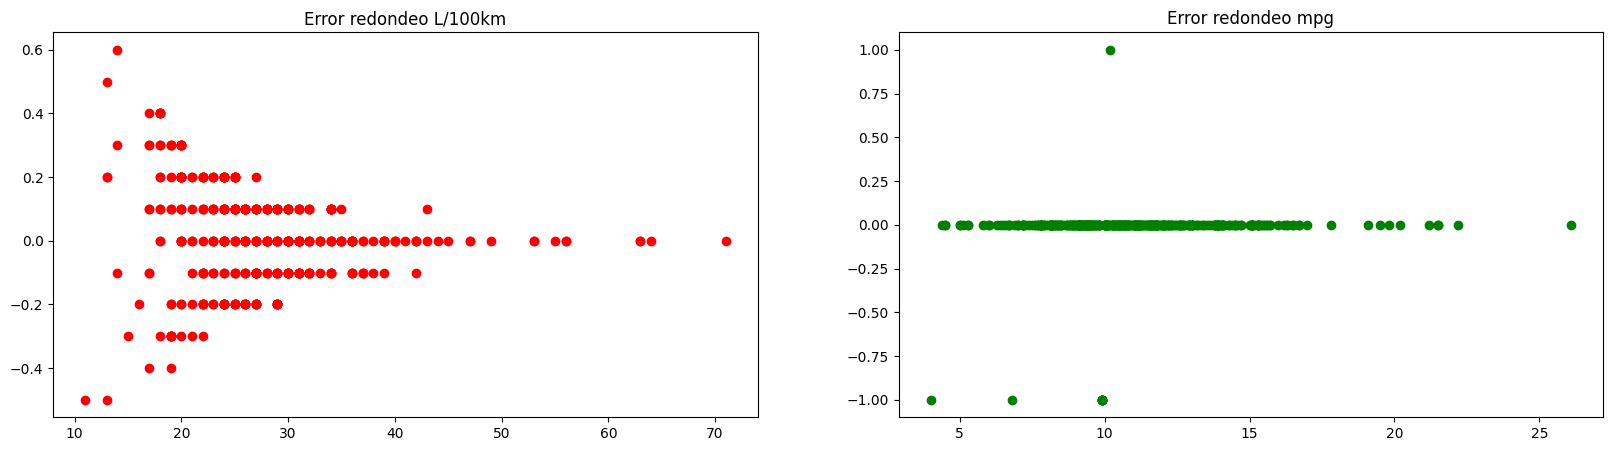

In [115]:

error_redonde_km = np.around(282/test_nolabel['Comb (mpg)'],1) - test_nolabel['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/test_nolabel['Comb (L/100 km)']) - test_nolabel['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(test_nolabel['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(test_nolabel['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')

Lo mismo observamos en test pero además se le añaden los errores +1, es decir, ha redondeado hacia abajo el dataset original cuando debería haber redondeado hacia arriba.

In [116]:
copy = test_nolabel.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg
premisa = (copy['error_redondeo_mpg'] < -0.5) | (copy['error_redondeo_mpg'] > 0.5)
outliers_error = copy[premisa]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']
outliers_error

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
3,29,9.9,-1.0,28.484848
15,29,9.9,-1.0,28.484848
31,27,10.2,1.0,27.647059
35,71,4.0,-1.0,70.500000
58,29,9.9,-1.0,28.484848
62,29,9.9,-1.0,28.484848
101,42,6.8,-1.0,41.470588
238,29,9.9,-1.0,28.484848
296,29,9.9,-1.0,28.484848


#### Fuel Consumption City (L/100 km) , Hwy (L/100 km) y Comb (L/100 km)

Ya que uno hace referencia al consumo en ciudad, otro al consumo en carretera y el último al consumo combinado, podemos sacar información de los tres.

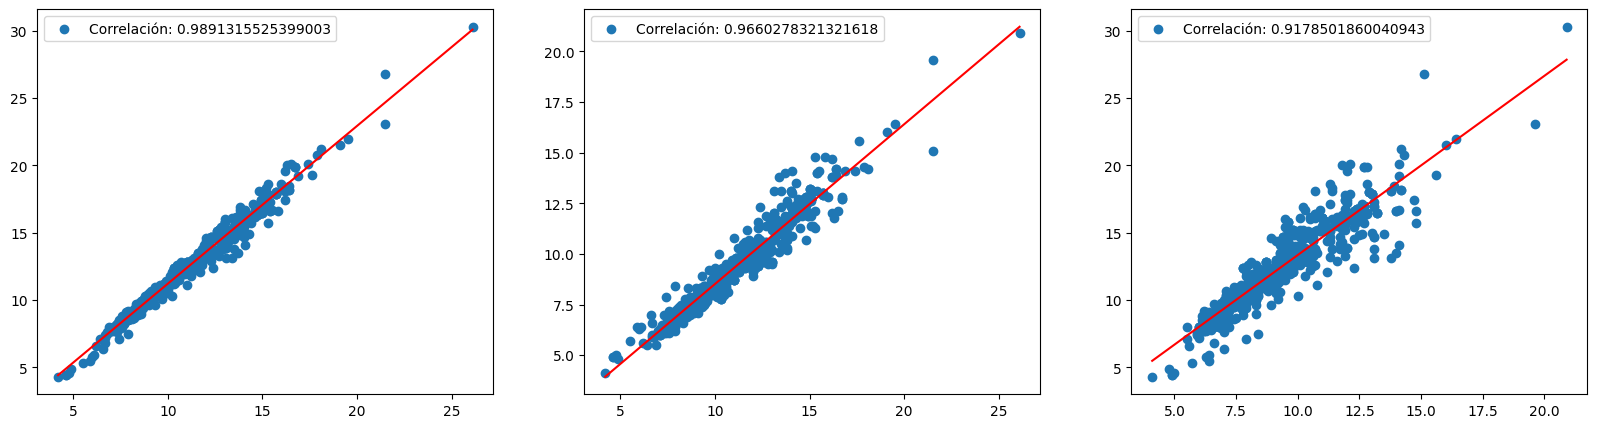

In [117]:
corr_representation(train)


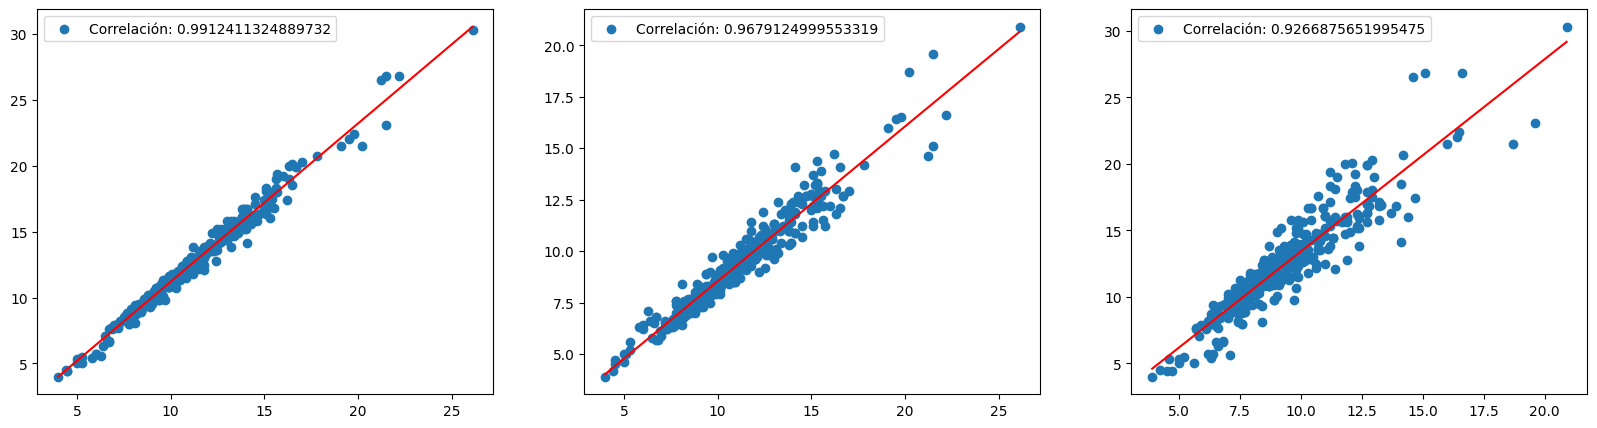

In [118]:
corr_representation(test_nolabel)

En el test encontramos la misma correlación lineal entre los diferentes atributos

Como hemos observado existe una correlación lineal entre los tres atributos. Vamos a estudiar una regresión lineal para ver si podemos predecir el consumo combinado a partir del consumo en ciudad y en carretera.

C:\Users\andre\AppData\Local\Temp\ipykernel_26440\3384525203.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error,ax=fig[1])


r_2: 0.999846023883621
parametres: [[0.54881468 0.45188741]]


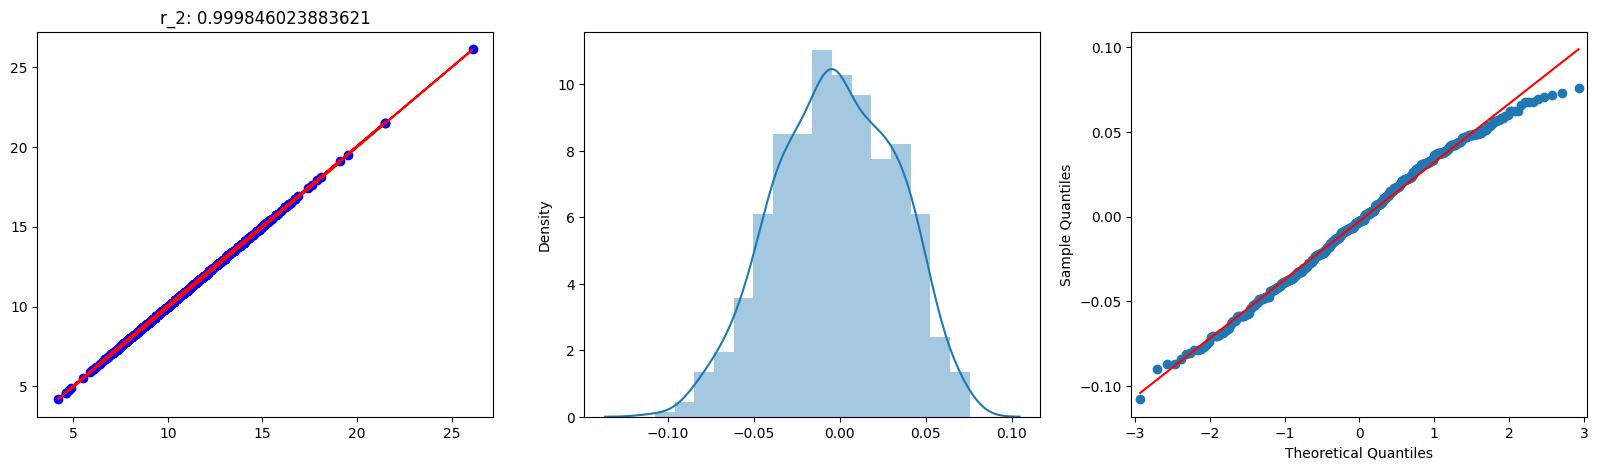

In [119]:
r_2_regresion_lineal(train,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

C:\Users\andre\AppData\Local\Temp\ipykernel_26440\3384525203.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error,ax=fig[1])


r_2: 0.9997950715122937
parametres: [[0.55073582 0.44928444]]


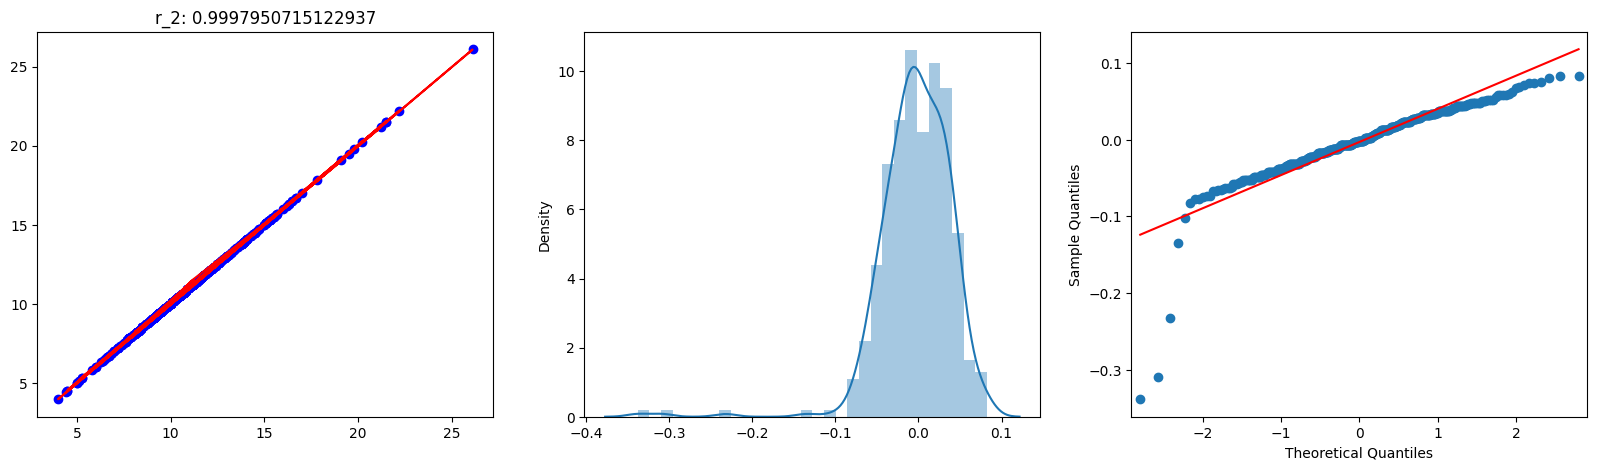

In [120]:
r_2_regresion_lineal(test_nolabel,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

### comb = 0.55 * city + 0.45 * hwy

Podemos observar claramente quq el atributo Comb (L/100 km) está calculado a partir de Fuel Consumption City (L/100 km) y Hwy (L/100 km). por lo que nos vamos a quedar con Fuel Consumption City (L/100 km) y Hwy (L/100 km) y vamos a eliminar Comb (L/100 km), debido a que si lo hiciéramos al revés, podríamos perder información, aunque comb (L/100 km) esté calculado a partir de los otros dos.



#### CO2 EMISSIONS 

In [121]:
train.corr()

,Model Year,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
Model Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine Size (L),NaN,1.000000,0.916857,0.823824,0.722882,0.802054,-0.713731,0.808957,-0.385252
Cylinders,NaN,0.916857,1.000000,0.836961,0.716359,0.808126,-0.709976,0.819685,-0.452239
Fuel Consumption City (L/100 km),NaN,0.823824,0.836961,1.000000,0.917850,0.989132,-0.925557,0.962071,-0.485874
Hwy (L/100 km),NaN,0.722882,0.716359,0.917850,1.000000,0.966028,-0.888538,0.933776,-0.374793
Comb (L/100 km),NaN,0.802054,0.808126,0.989132,0.966028,1.000000,-0.930041,0.970278,-0.454922
Comb (mpg),NaN,-0.713731,-0.709976,-0.925557,-0.888538,-0.930041,1.000000,-0.926047,0.475578
CO2 Emissions (g/km),NaN,0.808957,0.819685,0.962071,0.933776,0.970278,-0.926047,1.000000,-0.481380
Smog,NaN,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,0.475578,-0.481380,1.000000


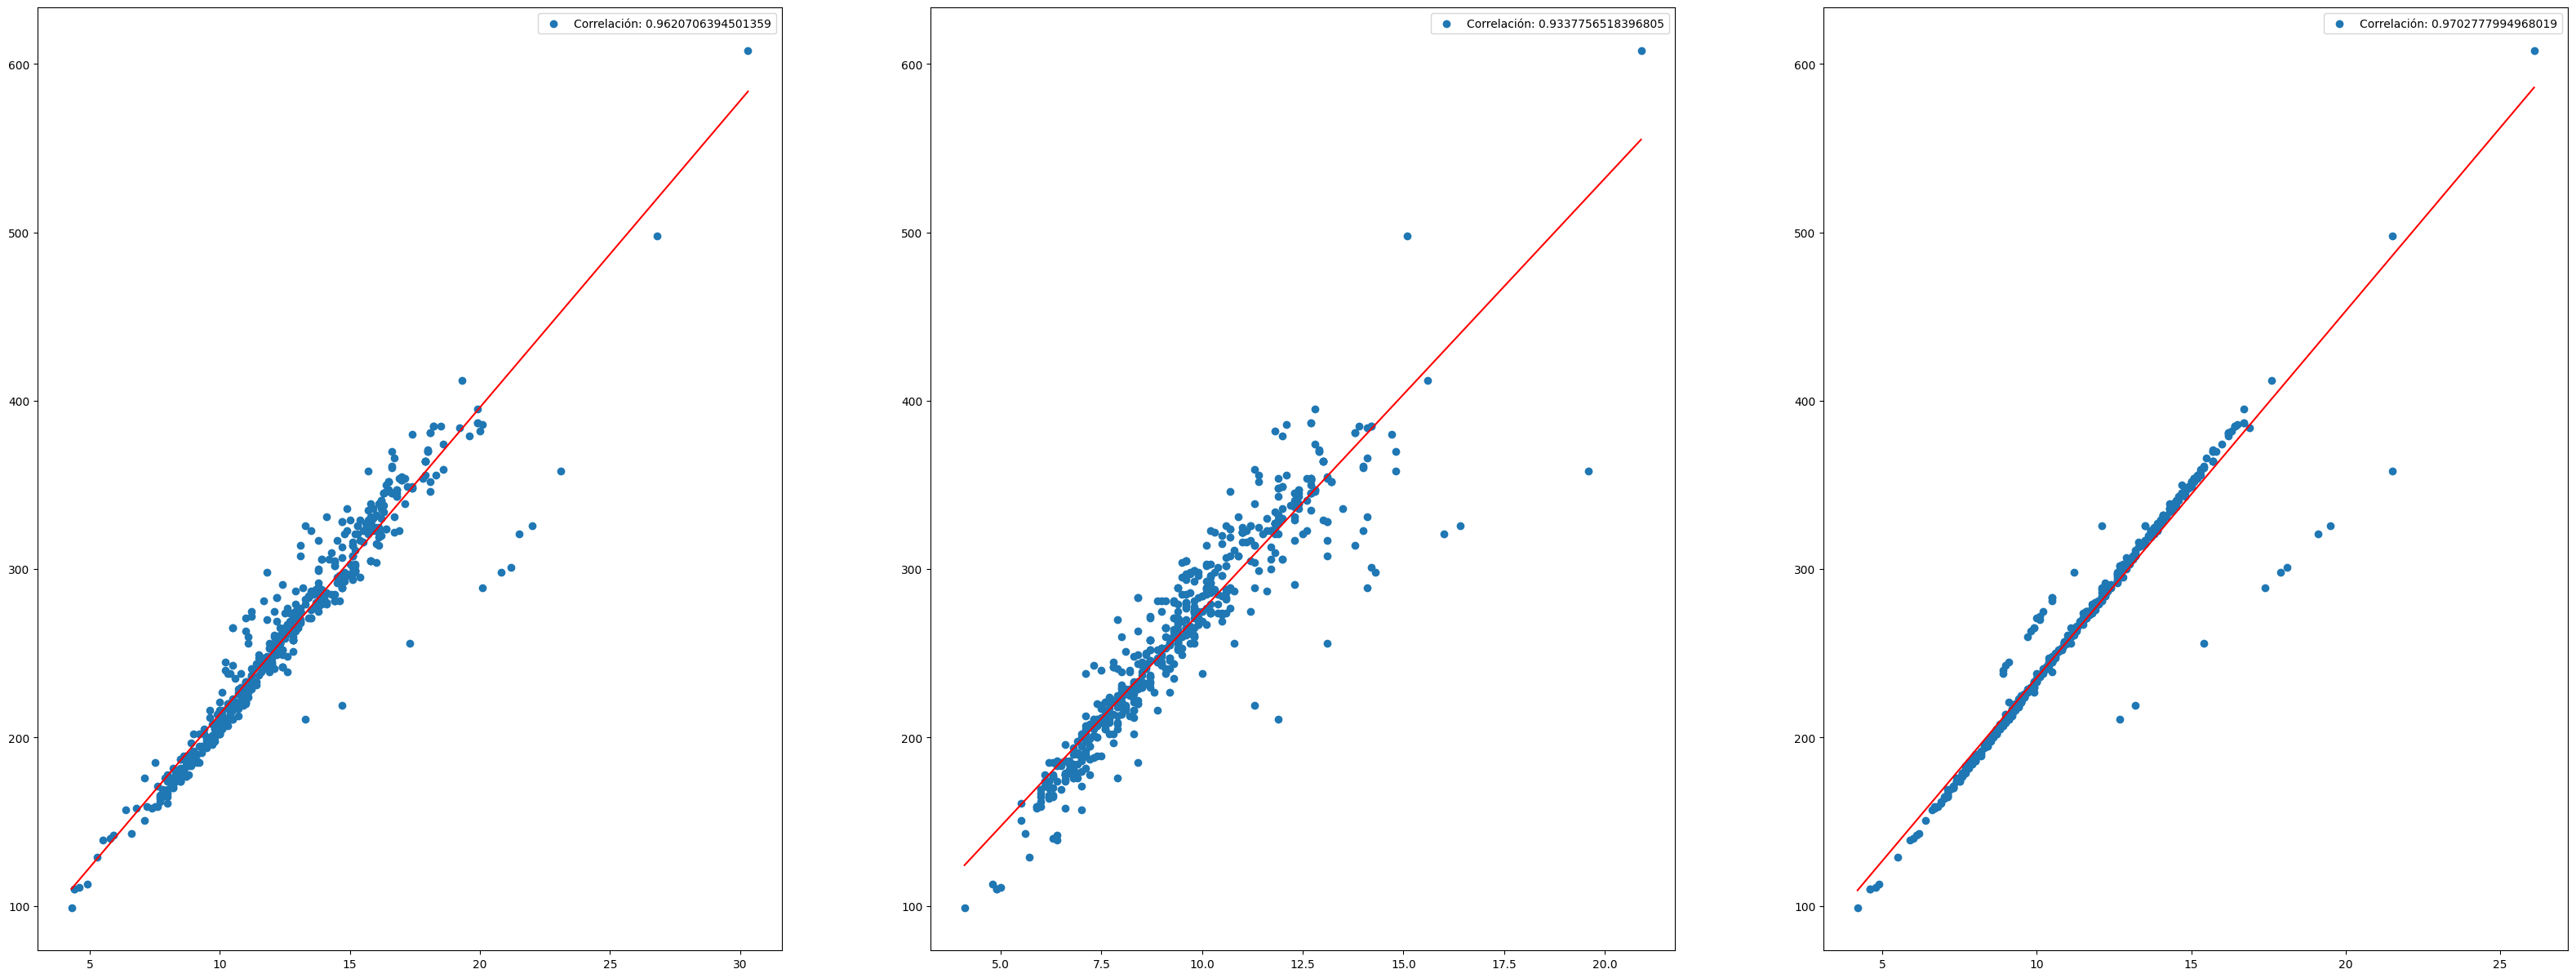

In [122]:
ax, fig = plt.subplots(1,3,figsize=(40,15))

corr_1 = train['Fuel Consumption City (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_2 = train['Hwy (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_3 = train['Comb (L/100 km)'].corr(train['CO2 Emissions (g/km)'])


fig[0].scatter(train['Fuel Consumption City (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[0].plot(np.unique(train['Fuel Consumption City (L/100 km)']), np.poly1d(np.polyfit(train['Fuel Consumption City (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Fuel Consumption City (L/100 km)'])),color='red')
fig[0].legend([f'Correlación: {corr_1}'])

fig[1].scatter(train['Hwy (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[1].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
fig[1].legend([f'Correlación: {corr_2}'])

fig[2].scatter(train['Comb (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[2].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
fig[2].legend([f'Correlación: {corr_3}'])



Hay existencia de correlación lineal entre CO2 Emissions y los demás atributos, pero no hemos observado una clara combinación lineal entre ellos. Por tanto, vamos a mantener todos los atributos.

### Outliers

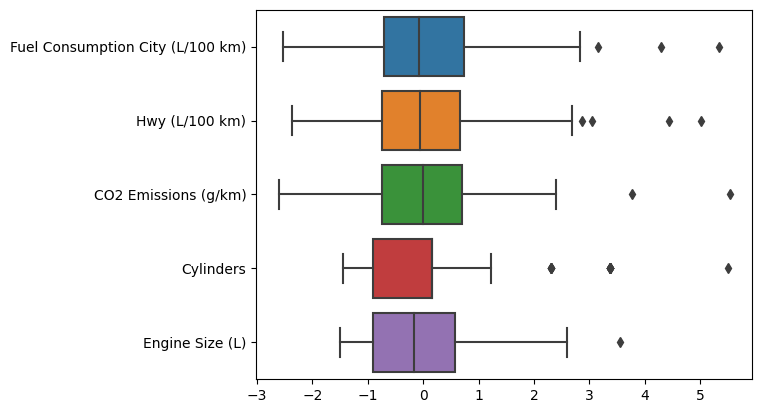

In [123]:
boxplot(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']])

In [130]:
outliers = outliers(train_out[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','CO2 Emissions (g/km)','Cylinders','Engine Size (L)']])['outliers']

In [134]:
index = outliers.index
outlier = train.loc[index]
outlier['outliers'] = outliers

Text(0.5, 1.0, 'Test')

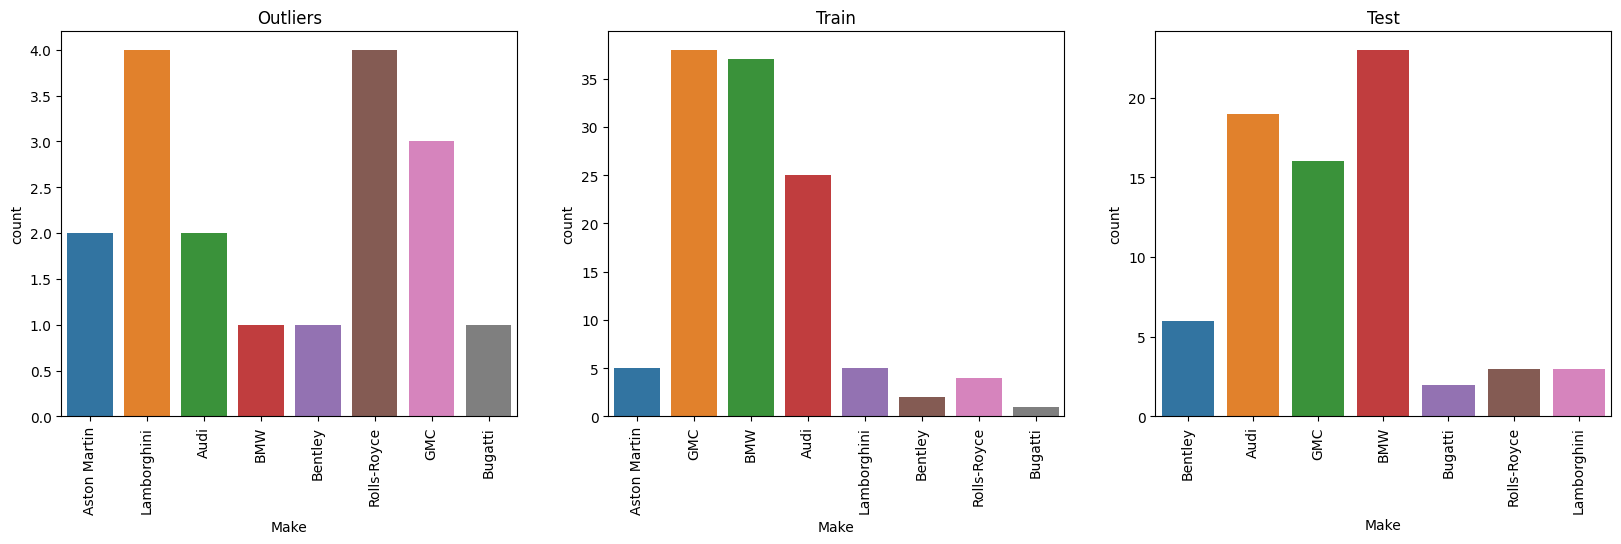

In [146]:
marcas = outlier['Make'].unique()

ax, fig = plt.subplots(1,3,figsize=(20,5))

sns.countplot(x='Make',data=outlier,ax=fig[0])
fig[0].tick_params(axis='x', rotation=90)
fig[0].set_title('Outliers')

train_marcas = train[train['Make'].isin(marcas)]
sns.countplot(x='Make',data=train_marcas,ax=fig[1])
fig[1].tick_params(axis='x', rotation=90)
fig[1].set_title('Train')

test_marcas = test_nolabel[test_nolabel['Make'].isin(marcas)]
sns.countplot(x='Make',data=test_marcas,ax=fig[2])
fig[2].tick_params(axis='x', rotation=90)
fig[2].set_title('Test')


No hemos podido progresar con los outliers, es verdad que encontramos que las marcas de los outliers justamente son las marcas de coches deportivos y por eso son outliers (cylinders, engine size...). Sin embargo no hemos podido eliminarlos porque no sabemos si son errores o no. 

### Smog 

<Axes: xlabel='Smog', ylabel='count'>

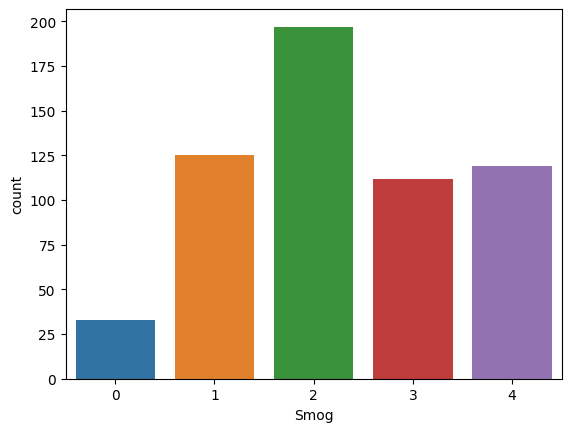

In [142]:
sns.countplot(x='Smog',data=train)

Terminamos el preprocesado mostrando el desbalanceo de la variable objetivo Smog, dicho desbalanceo sea tratará más adelante.